# Simulation of an Inverted Pendulum on a Wheel, Linearization
&copy; 2023 @RR_Inyo<br/>
Released under the MIT license.<br/>
https://opensource.org/licenses/mit-license.php<br/>

## Derivation of the equation of motion
In this notebook, the equation of motion for an inverted pendulum on a wheel is derived using `sympy.physics.mechanics` module.

<figure><img src="wheel-inverted-pendulum.png" style="zoom:0.5;"/><figcaption>Fig. 1: Inverted pendulum on a wheel</figcaption></figure>

Fig. 1 shows the system to be discussed. The horizontal and vertical axes are $x$ and $z$ axes. The wheel has a radius $a$, mass $M$, and inertia $J_{w}$. The $x$-axis position of the wheel is $x_{w}$. At the center of the wheel is attached the end of pendulum whose center of mass is located $l$ away from the pivot.
The mass and the intertia of the pendulum is $m$ and $J_{p}$, respectively. The angle of the pendulum from the vertical line is $\theta$ whereas the angle between the pendulum and the predifined reference line on the wheel is $\phi$. The position of the pendulum's center of mass is $(x_{p}, z_{p})$.

This notebook now derives the non-linear equation of motion by means of Langrangian method.

In [1]:
import sympy as sp
from sympy.physics.mechanics import *
init_vprinting()

In [2]:
# ------------------------------------------------
# Common symbols and reference frame
# ------------------------------------------------

# Define symbols, Common
t = sp.symbols('t')                                    # Time
g = sp.symbols('g')                                    # Gravity

# Define reference frame, Common
N = ReferenceFrame('N')
O = Point('O')                                         # Origin point
O.set_vel(N, 0)                                        # Origin point has zero velocity

In [3]:
# ------------------------------------------------
# Pendulum
# ------------------------------------------------

# Symbols
m, J_p, l, mu_p = sp.symbols('m J_p l mu_p')           # Mass, Inertia, length, and friction
theta = dynamicsymbols('theta')                        # Angle with respect to vertical line

# Reference frame and rigid body
N_p = N.orientnew('N_p', 'Axis', (theta, N.y))         # Define new reference frame for pendulum
N_p.set_ang_vel(N, theta.diff(t, 1) * N.y)             # Set angular velocity of reference frame
C_p = Point('C_p')                                     # Mass center of pendulum
J_p_tensor = J_p * outer(N_p.y, N_p.y)                 # Inertia tensor
P = RigidBody('P', C_p, N_p, m, (J_p_tensor, C_p))     # Definition of rigid body

In [4]:
# ------------------------------------------------
# Wheel
# ------------------------------------------------

# Symbols
M, J_w, a, mu_w = sp.symbols('M J_w a mu_w')
phi = dynamicsymbols('phi')

# Reference frame and rigid body
N_w = N_p.orientnew('B', 'Axis', (phi, N_p.y))         # Define new reference frame for pendulum
N_w.set_ang_vel(N_p, phi.diff(t, 1) * N_p.y)             # Set angular velocity of reference frame
C_w = Point('C_w')                                     # Center of wheel
J_w_tensor = J_w * outer(N_w.y, N_w.y)                 # Intertia tensor
W = RigidBody('W', C_w, N_w, M, (J_w_tensor, C_w))     # Definition of rigid body

In [5]:
# ------------------------------------------------
# Constraints
# ------------------------------------------------

# Set positions
C_w.set_pos(O, a * ((theta + phi) * N.x + N.z))
C_p.set_pos(C_w, l * (sp.sin(theta) * N.x + sp.cos(theta) * N.z))

# Set velocities
C_w.set_vel(N, a * (theta.diff(t, 1) + phi.diff(t, 1)) * N.x)
C_p.set_vel(N, (a * (theta.diff(t, 1) + phi.diff(t, 1)) 
   + l * theta.diff(t, 1) * sp.cos(theta)) * N.x \
   - l * theta.diff(t, 1) * sp.sin(theta) * N.z)

# # Define pin joint
# J = PinJoint('J', W, P, \
#              coordinates = [theta], \
#              parent_joint_pos = C_w, \
#              child_joint_pos = -l * P.frame.z, \
#              parent_axis = W.frame.y, \
#              child_axis = P.frame.y)
             
# Point to apply disturbance
P_d = Point('P_d')
P_d.set_pos(C_p, l * N_p.z)
P_d.set_vel(N, (a * (theta.diff(t, 1) + phi.diff(t, 1)) \
    + 2 * l * theta.diff(t, 1) * sp.cos(theta)) * N.x \
    - 2 * l * theta.diff(t, 1) * sp.sin(theta) * N.z)

In [6]:
# ------------------------------------------------
# Kinetic energies
# ------------------------------------------------
print('Kinetic energy, Pendulum:')
display(P.kinetic_energy(N))

print('Kinetic energy, Wheel:')
display(W.kinetic_energy(N))

Kinetic energy, Pendulum:


Kinetic energy, Wheel:


In [7]:
# ------------------------------------------------
# Potential energies
# ------------------------------------------------
P.potential_energy = m * g * l * sp.cos(theta)
print('Potential energy of pendulum:')
display(P.potential_energy)

Potential energy of pendulum:


In [8]:
# ------------------------------------------------
# Euler-Lagrange method
# ------------------------------------------------

# Get Lagrangian
L = Lagrangian(N, P, W)
print('Lagrangian:')
display(L)

# Generalized coordinate
q = [theta, phi]

# Generalized forces and torques
# Control torque
tau = dynamicsymbols('tau')
f_control = [(N_p, -tau * N_p.y), (N_w, tau * N_w.y)]

# Friction or dissipative
# Friction between pendulum and wheel
tau_fp = sp.symbols('tau_fp')
tau_fp = mu_p * phi.diff(t, 1)

# Friction between pendulum and wheel and friction between wheel and floor
tau_fw = sp.symbols('tau_fw')
tau_fw = -mu_p * phi.diff(t, 1) - mu_w * (theta.diff(t, 1) + phi.diff(t, 1))

f_dissipation = [(N_p, tau_fp * N_p.y), (N_w, tau_fw * N_w.y)]

# Disturbance force
f_d = dynamicsymbols('f_d')
f_disturbance = [(P_d, f_d * N.x)]

# Summation of generalized forces and torques
f = f_control + f_dissipation + f_disturbance

# Define a Lagrange's method
LM = LagrangesMethod(L, q, forcelist = f, frame = N)

# Derive equation of motion!
eom = LM.form_lagranges_equations()
print('Equation of motion:')
display(eom[0].simplify().expand())
display(eom[1].simplify().expand())

Lagrangian:


Equation of motion:


Equation with respect to d^2 theta / dt^2


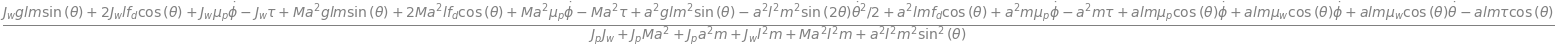

Equation with respect to d^2 phi / dt^2


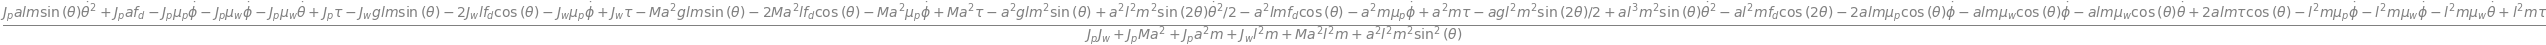

In [9]:
# ------------------------------------------------
# Angular acceleration
# ------------------------------------------------

# Solve equation of motion with respect to the second-order variables
sol = sp.solve(eom, [theta.diff(t, 2), phi.diff(t, 2)])

eq1 = sol[theta.diff(t, 2)].simplify()
print('Equation with respect to d^2 theta / dt^2')
display(eq1)

eq2 = sol[phi.diff(t, 2)].simplify()
print('Equation with respect to d^2 phi / dt^2')
display(eq2)

## Linearization

In [10]:
# ------------------------------------------------
# Linearization
# ------------------------------------------------

# Set operating point
op_point = {theta: 0, theta.diff(t, 1): 0, phi: 0, phi.diff(t, 1): 0}

# Linearize!
kwargs = {'q_ind': [theta, phi], 'qd_ind': [theta.diff(t, 1), phi.diff(t, 1)], \
          'A_and_B': True, 'op_point': op_point, 'simplify': True}
A, B, inp_vec = LM.linearize(**kwargs)

In [11]:
# ------------------------------------------------
# Results of linearization
# ------------------------------------------------
print('A =')
display(A)

print('B =')
display(B)

print('inp_vec =')
display(inp_vec)

A =


⎡                        0                          0                         
⎢                                                                             
⎢                        0                          0                         
⎢                                                                             
⎢                  ⎛         2    2  ⎞                                        
⎢            g⋅l⋅m⋅⎝J_w + M⋅a  + a ⋅m⎠                                     a⋅l
⎢─────────────────────────────────────────────────  0  ───────────────────────
⎢               2       2          2        2  2                      2       
⎢Jₚ⋅J_w + Jₚ⋅M⋅a  + Jₚ⋅a ⋅m + J_w⋅l ⋅m + M⋅a ⋅l ⋅m     Jₚ⋅J_w + Jₚ⋅M⋅a  + Jₚ⋅a
⎢                                                                             
⎢              ⎛          2    2          ⎞                             ⎛     
⎢        g⋅l⋅m⋅⎝-J_w - M⋅a  - a ⋅m - a⋅l⋅m⎠                         μ_w⋅⎝-Jₚ -
⎢─────────────────────────────────────────────────  

B =


⎡                        0                                                    
⎢                                                                             
⎢                        0                                                    
⎢                                                                             
⎢              ⎛             2    2  ⎞                                        
⎢            l⋅⎝2⋅J_w + 2⋅M⋅a  + a ⋅m⎠                                        
⎢─────────────────────────────────────────────────                 ───────────
⎢               2       2          2        2  2                              
⎢Jₚ⋅J_w + Jₚ⋅M⋅a  + Jₚ⋅a ⋅m + J_w⋅l ⋅m + M⋅a ⋅l ⋅m                 Jₚ⋅J_w + Jₚ
⎢                                                                             
⎢                         2      2          2                                 
⎢   Jₚ⋅a - 2⋅J_w⋅l - 2⋅M⋅a ⋅l - a ⋅l⋅m - a⋅l ⋅m                               
⎢─────────────────────────────────────────────────  

inp_vec =


⎡f_d⎤
⎢   ⎥
⎣ τ ⎦

## Simulation of inverted pendulum on a wheel
Now that the equations of motion have been derived, a simulation by `scipy.integrate.solve_ivp` is ready to be done.
The equtions derived by SymPy are transformed into Python functions using the Lambdify finctionality of SymPy.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from scipy.linalg import solve_continuous_are
from scipy.integrate import solve_ivp
import scipy.constants as cnst
from IPython.display import HTML

In [13]:
# ------------------------------------------------
# Numerical parameter examples
# ------------------------------------------------

# Reset format
np.set_printoptions(formatter = None)

# Pendulum
_m = 1.50                    # Mass of pendulum, kg
_l = 0.30                    # Half length of pendulum, m
_J_p = _m * _l**2 / 3        # Inertia of pendulum
_mu_p = 0.05                 # Friction of pendulum, N/(rad/s)

# Wheel
_M = 0.75                    # Mass of wheel, kg
_a = 0.10                    # Radius of wheel, m
_J_w = _M * _a**2 / 2        # Inertia of wheel, kg m**2
_mu_w = 0.05                 # Friction of wheel, N/(rad/s)

# Gravity
_g = cnst.g                  # Gravity on Earth, m/s**2

In [14]:
# ------------------------------------------------
# Lambdification of SymPy results
# ------------------------------------------------

# Give derivatives new name
theta_dot, phi_dot = sp.symbols('theta_dot phi_dot')

# Definition of the lambdified functions
_eq1 = eq1.subs([(theta.diff(t, 1), theta_dot), (phi.diff(t, 1), phi_dot), \
                 (m, _m), (l, _l), (J_p, _J_p), (M, _M), (a, _a), (J_w, _J_w), (mu_p, _mu_p), (mu_w, _mu_w), (g, _g)])
func_eq1 = sp.lambdify([theta, theta_dot, phi, phi_dot, tau, f_d], _eq1, 'numpy')

_eq2 = eq2.subs([(theta.diff(t, 1), theta_dot), (phi.diff(t, 1), phi_dot), \
                 (m, _m), (l, _l), (J_p, _J_p), (M, _M), (a, _a), (J_w, _J_w), (mu_p, _mu_p), (mu_w, _mu_w), (g, _g)])
func_eq2 = sp.lambdify([theta, theta_dot, phi, phi_dot, tau, f_d], _eq2, 'numpy')

In [15]:
# ------------------------------------------------
# Linearization results to NumPy arrays, A and B
# ------------------------------------------------

# NOTE:
#  x = [theta, phi, theta_dot, phi_dot]^T
#  u = [f_d, tau]^T

# The A matrix
_A_tmp = sp.matrix2numpy(A.subs([(m, _m), (l, _l), (J_p, _J_p), (M, _M), (a, _a), (J_w, _J_w), (mu_p, _mu_p), (mu_w, _mu_w), (g, _g)]), dtype = 'float64')

# The B matrix
_B_tmp = sp.matrix2numpy(B.subs([(m, _m), (l, _l), (J_p, _J_p), (M, _M), (a, _a), (J_w, _J_w), (mu_p, _mu_p), (mu_w, _mu_w), (g, _g)]), dtype = 'float64')

# Change raw and column orders to fit existing routines
_A_tmp = _A_tmp[[0, 2, 1, 3], :]
_A = _A_tmp[:, [0, 2, 1, 3]]
print(f'A = \n{_A}')

_B_tmp = _B_tmp[[0, 2, 1, 3], :]
_B = _B_tmp[:, [1, 0]]
print(f'B = \n{_B}')

A = 
[[   0.            1.            0.            0.        ]
 [  42.90409375    0.83333333    0.            2.15277778]
 [   0.            0.            0.            1.        ]
 [-116.45396875   -4.16666667    0.           -9.65277778]]
B = 
[[  0.           0.        ]
 [-26.38888889   4.16666667]
 [  0.           0.        ]
 [109.72222222  -7.5       ]]


In [16]:
# ------------------------------------------------
# Check linearized system characteristics
# ------------------------------------------------

# Eigenvalue of A
print('Check stability of open-loop system...')
w, v = np.linalg.eig(_A)
print(f'Eigenvalues =\n{w}\n')

# Controllability
print('Check Controllability...')
_B_c = np.array(_B[:, 0])
U_c = np.array([_B_c, _A @ _B_c, _A @ _A @ _B_c, _A @ _A @ _A @ _B_c])
print(f'U_c =\n{U_c}')
print(f'Rank of U_c = {np.linalg.matrix_rank(U_c)}\n')

# Observability
print('Check observability...')
_C = np.array([0, 1, 0, 1])
U_o = np.array([_C, _C @ _A, _C @ _A @ _A, _C @ _A @ _A @ _A])
print(f'C = \n{_C}')
print(f'U_o =\n{U_o}')
print(f'Rank of U_o = {np.linalg.matrix_rank(U_o)}')

Check stability of open-loop system...
Eigenvalues =
[  0.           5.22013504  -2.78102636 -11.25855313]

Check Controllability...
U_c =
[[ 0.00000000e+00 -2.63888889e+01  0.00000000e+00  1.09722222e+02]
 [-2.63888889e+01  2.14216821e+02  1.09722222e+02 -9.49170525e+02]
 [ 2.14216821e+02 -2.99703056e+03 -9.49170525e+02  1.13426529e+04]
 [-2.99703056e+03  3.11114642e+04  1.13426529e+04 -1.21946880e+05]]
Rank of U_c = 4

Check observability...
C = 
[0 1 0 1]
U_o =
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-7.35498750e+01 -3.33333333e+00  0.00000000e+00 -7.50000000e+00]
 [ 7.30391120e+02 -4.50776528e+01  0.00000000e+00  6.52199074e+01]
 [-9.52913290e+03  4.21076795e+02  0.00000000e+00 -7.26595442e+02]]
Rank of U_o = 3


In [17]:
# ------------------------------------------------
# LQR
# ------------------------------------------------
# Weights
_B_c = np.array([_B[:, 0]]).T    # As a column vector here
_Q = np.diag([30, 0, 1, 0])
_R = np.array([[20]])

# Solve Riccati equation
_P = solve_continuous_are(_A, _B_c, _Q, _R)
_F = (-np.linalg.inv(_R) @ _B_c.T @ _P)[0]
print(f'State-feedback gain _F =\n{_F}\n')

# Check eigenvalues of closed-loop system
w_lqr, v_lqr = np.linalg.eig(_A + _B_c * _F)
print(f'Eigenvalues of closed-loop system =\n{w_lqr}')

State-feedback gain _F =
[7.28536263 1.56361032 0.2236068  0.26065262]

Eigenvalues of closed-loop system =
[-10.32317056+0.j          -6.85291923+0.j
  -2.15295452+0.72864352j  -2.15295452-0.72864352j]


In [18]:
# ------------------------------------------------
# Torque for control
# ------------------------------------------------

# State feedback gain, preliminary, tuned by try and error
# This is obtained by linearization and LQR!
F = _F

# Maximum torque, Nm
tau_max = 3

def torque_control(t, x):
    # State variable x = [theta, theta_dot, phi, phi_dot]^T
    theta, theta_dot, phi, phi_dot = x
    if t < 15:
        # State-feedback control
        tau = np.clip(F @ x, -tau_max, tau_max)
        
        # PID control
        # Kp, Ki, Kd = 30.0, 0.0, 0.0
        # tau = Kp * theta
    else:
        # Stop controlling
        tau = 0
    
    # # Zero torque for test
    # tau = 0
    
    return tau

In [19]:
# ------------------------------------------------
# Disturbance force
# ------------------------------------------------
def force_disturbance(t, x):
    # State variable x = [theta, theta_dot, phi, phi_dot]^T
    if 5 <= t < 5.5:
        f_d = 5
    elif 9 <= t < 12:
        f_d = 5 * np.sin(2 * np.pi * 1 * (t - 9))
    else:
        f_d = 0
    
    # # Zero force for test
    # f_d = 0
    
    return f_d

In [20]:
# ------------------------------------------------
# Non-linear state-space equation
# ------------------------------------------------
def func(t, x):
    # Extract state variables
    # State variable x = [theta, theta_dot, phi, phi_dot]^T
    theta, theta_dot, phi, phi_dot = x
    
    # Torque for control
    tau = torque_control(t, x)
    
    # Disturbance
    f_d = force_disturbance(t, x)
    
    # Calculate derivative of state x
    dxdt = np.zeros_like(x)
    dxdt[0] = theta_dot
    dxdt[1] = func_eq1(theta, theta_dot, phi, phi_dot, tau, f_d)
    dxdt[2] = phi_dot
    dxdt[3] = func_eq2(theta, theta_dot, phi, phi_dot, tau, f_d)
    
    # Return result
    return dxdt

In [21]:
# ------------------------------------------------
# Linearized state-space equation
# ------------------------------------------------
def func_lin(t, x):
    # Extract state variables
    # State variable x = [theta, theta_dot, phi, phi_dot]^T
    theta, theta_dot, phi, phi_dot = x
    
    # Torque for control
    tau = torque_control(t, x)
    
    # Disturbance
    f_d = force_disturbance(t, x)
    
    # Input vector
    u = np.array([tau, f_d])
    
    # Calculate derivative of state x
    dxdt = _A @ x + _B @ u
    
    # Return result
    return dxdt

In [22]:
# ------------------------------------------------
# Solution of non-lin. and lin. dynamics by SciPy
# ------------------------------------------------

# NumPy array for time
t_end = 20                        # Time to end simulation, s
dt = 0.01                         # Time slice, s
_t = np.arange(0, t_end, dt)      # Time array

# Initial conditions
theta_0 = np.radians(30)          # Initial pendulum angle, rad
x_w0 = 1                          # Initial wheel positon, m
phi_0 = x_w0 / _a - theta_0       # Initial wheel angle with respect to pendulum
x0 = [theta_0, 0, phi_0, 0]       # Initial state

# Now solve it, non-linear
sol = solve_ivp(func, [0, t_end], x0, t_eval = _t)

# Now solve it, linearized
sol_lin = solve_ivp(func_lin, [0, t_end], x0, t_eval = _t)

In [23]:
# ------------------------------------------------
# Post-processing of the solution, non-linear
# ------------------------------------------------

# State variables
_theta = (sol.y[0,:].T + np.pi) % (2 * np.pi) - np.pi
_theta_dot = sol.y[1,:].T
_phi = (sol.y[2,:].T + np.pi) % (2 * np.pi) - np.pi
_phi_dot = sol.y[3,:].T

# Position and velocity of wheel, theta + phi
_x_w = _a * (sol.y[0,:].T + sol.y[2,:].T)
_v_w = _a * (sol.y[1,:].T + sol.y[3,:].T)

# Reproduce control torque and disturbance force
_tau_cont = np.zeros_like(_t)
_f_d = np.zeros_like(_t)
for i, __t in enumerate(_t):
    _tau_cont[i] = torque_control(__t, sol.y[:,i])
    _f_d[i] = force_disturbance(__t, sol.y[:,i])

In [24]:
# ------------------------------------------------
# Post-processing of the solution, linearized
# ------------------------------------------------

# State variables
_theta_lin = (sol_lin.y[0,:].T + np.pi) % (2 * np.pi) - np.pi
_theta_dot_lin = sol_lin.y[1,:].T
_phi_lin = (sol_lin.y[2,:].T + np.pi) % (2 * np.pi) - np.pi
_phi_dot_lin = sol_lin.y[3,:].T

# Position and velocity of wheel, theta + phi
_x_w_lin = _a * (sol_lin.y[0,:].T + sol_lin.y[2,:].T)
_v_w_lin = _a * (sol_lin.y[1,:].T + sol_lin.y[3,:].T)

# Reproduce control torque and disturbance force
_tau_cont_lin = np.zeros_like(_t)
_f_d_lin = np.zeros_like(_t)
for i, __t in enumerate(_t):
    _tau_cont_lin[i] = torque_control(__t, sol_lin.y[:,i])
    _f_d_lin[i] = force_disturbance(__t, sol_lin.y[:,i])

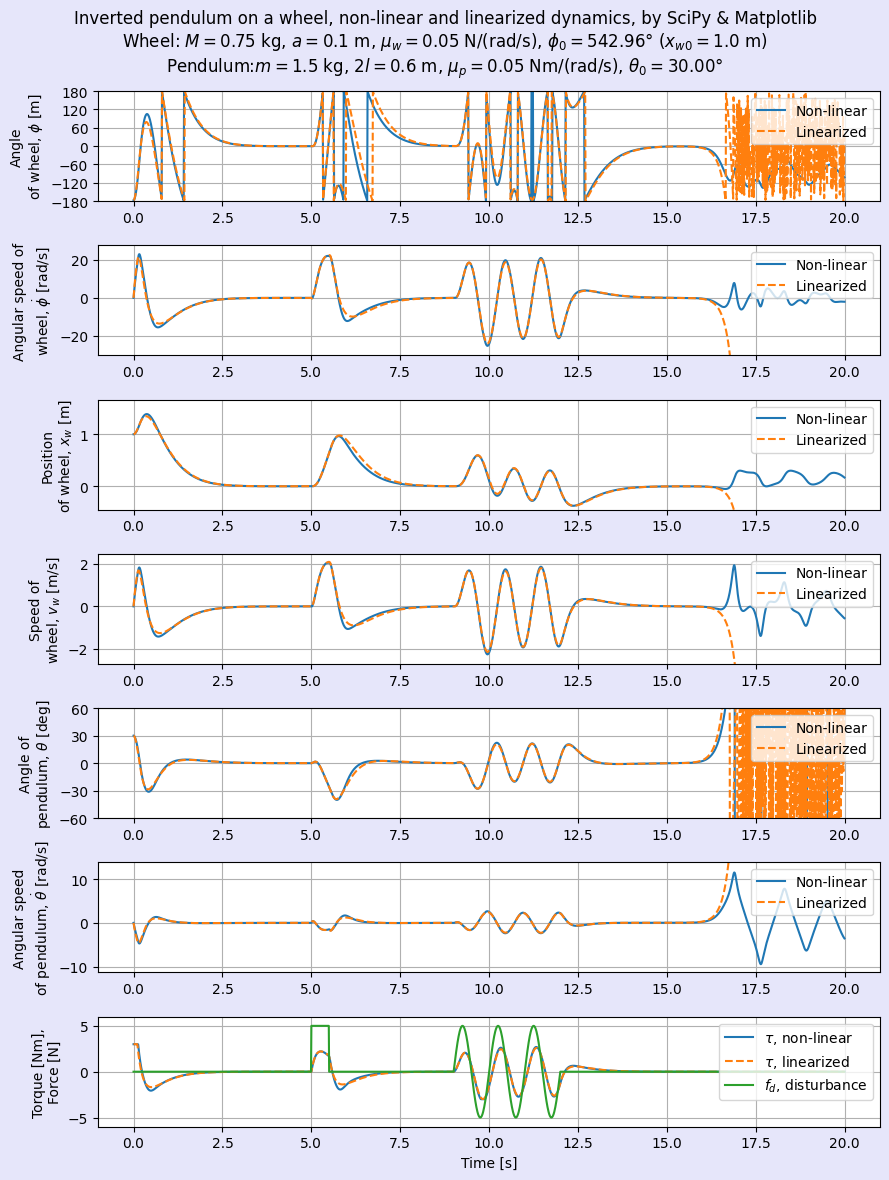

In [25]:
# ------------------------------------------------
# Time domain plots
# ------------------------------------------------

# Figure
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(7, 1, figsize = (9, 12))
fig.patch.set_facecolor('lavender')
fig.suptitle(f'Inverted pendulum on a wheel, non-linear and linearized dynamics, by SciPy & Matplotlib\nWheel: $M = {_M}$ kg, $a = {_a}$ m, $\mu_w = {_mu_w}$ N/(rad/s), $\\phi_0 = {np.degrees(phi_0):.2f}\degree$ ($x_{{w0}} = {_a * (theta_0 + phi_0):.1f}$ m)\nPendulum:$m = {_m}$ kg, $2l = {2 * _l}$ m, $\mu_p = {_mu_p}$ Nm/(rad/s), $\\theta_0 = {np.degrees(theta_0):.2f}\degree$')

# Plot wheel angle
ax[0].plot(_t, np.degrees(_phi), label = 'Non-linear')
ax[0].plot(_t, np.degrees(_phi_lin), ls = '--', label = 'Linearized')
ax[0].set_ylim(np.min(np.degrees(_phi)) * 1.2, np.max(np.degrees(_phi)) * 1.2)
ax[0].set_ylim(-180, 180)
ax[0].set_yticks(range(-180, 240, 60))
ax[0].set_ylabel('Angle\nof wheel, $\phi$ [m]')
ax[0].legend(loc = 'upper right')
ax[0].grid()

# Plot angular speed of wheel
ax[1].plot(_t, _phi_dot, label = 'Non-linear')
ax[1].plot(_t, _phi_dot_lin, ls = '--', label = 'Linearized')
ax[1].set_ylim(np.min(_phi_dot) * 1.2, np.max(_phi_dot) * 1.2)
ax[1].set_ylabel('Angular speed of\nwheel, $\dot{\phi}$ [rad/s]')
ax[1].legend(loc = 'upper right')
ax[1].grid()

# Plot wheel position
ax[2].plot(_t, _x_w, label = 'Non-linear')
ax[2].plot(_t, _x_w_lin, ls = '--', label = 'Linearized')
ax[2].set_ylim(np.min(_x_w) * 1.2, np.max(_x_w) * 1.2)
ax[2].set_ylabel('Position\nof wheel, $x_{w}$ [m]')
ax[2].legend(loc = 'upper right')
ax[2].grid()

# Plot speed of wheel
ax[3].plot(_t, _v_w, label = 'Non-linear')
ax[3].plot(_t, _v_w_lin, ls = '--', label = 'Linearized')
ax[3].set_ylim(np.min(_v_w) * 1.2, np.max(_v_w) * 1.2)
ax[3].set_ylabel('Speed of\nwheel, $v_{w}$ [m/s]')
ax[3].legend(loc = 'upper right')
ax[3].grid()

# Plot angle of pendulum
ax[4].plot(_t, np.degrees(_theta), label = 'Non-linear')
ax[4].plot(_t, np.degrees(_theta_lin), ls = '--', label = 'Linearized')
ax[4].set_ylabel('Angle of\npendulum, $\\theta$ [deg]')
ax[4].set_ylim(-60, 60)
ax[4].set_yticks(range(-60, 90, 30))
ax[4].legend(loc = 'upper right')
ax[4].grid()

# Plot angular speed of pendulum
ax[5].plot(_t, _theta_dot, label = 'Non-linear')
ax[5].plot(_t, _theta_dot_lin, ls = '--', label = 'Linearized')
ax[5].set_ylim(np.min(_theta_dot) * 1.2, np.max(_theta_dot) * 1.2)
ax[5].set_ylabel('Angular speed\nof pendulum, $\dot{\\theta}$ [rad/s]')
ax[5].legend(loc = 'upper right')
ax[5].grid()

# Control torque
ax[6].plot(_t, _tau_cont, label = '$\\tau$, non-linear')
ax[6].plot(_t, _tau_cont_lin, ls = '--', label = '$\\tau$, linearized')
ax[6].plot(_t, _f_d, label = '$f_{d}$, disturbance')
ax[6].set_ylim(np.min([_tau_cont, _f_d]) * 1.2, np.max([_tau_cont, _f_d]) * 1.2)
ax[6].set_xlabel('Time [s]')
ax[6].set_ylabel('Torque [Nm],\nForce [N]')
ax[6].legend(loc = 'upper right')
ax[6].grid()

fig.tight_layout()

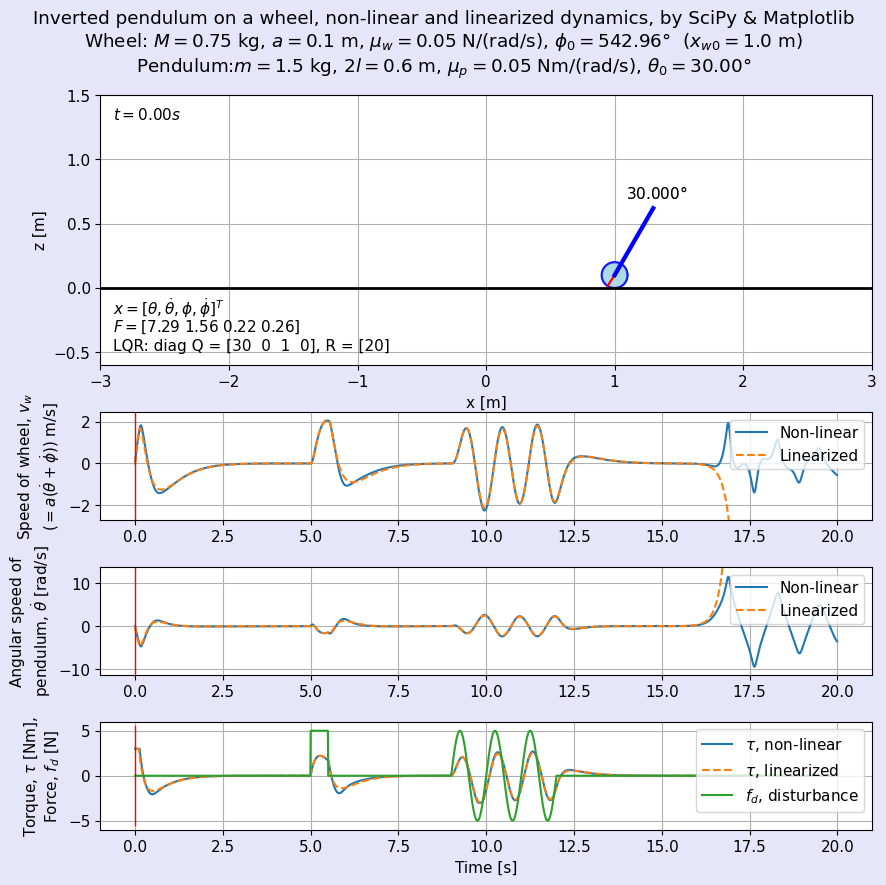

In [26]:
# ------------------------------------------------
# Animation theatre
# ------------------------------------------------

# Size of theatre
K_tscale = 3

# Alpha of linearized pendulum
alpha_lin = 0.4

# Color map
cmap = plt.get_cmap('tab10')

# Plot theatre
plt.rcParams["font.size"] = 11
fig, ax = plt.subplots(4, 1, figsize = (9, 9), gridspec_kw={'height_ratios': [2.5, 1, 1, 1]})
fig.patch.set_facecolor('lavender')
ax[0].set_aspect('equal')
fig.suptitle(f'Inverted pendulum on a wheel, non-linear and linearized dynamics, by SciPy & Matplotlib\nWheel: $M = {_M}$ kg, $a = {_a}$ m, $\mu_w = {_mu_w}$ N/(rad/s), $\\phi_0 = {np.degrees(phi_0):.2f}\degree$  ($x_{{w0}} = {_a * (theta_0 + phi_0):.1f}$ m)\nPendulum:$m = {_m}$ kg, $2l = {2 * _l}$ m, $\mu_p = {_mu_p}$ Nm/(rad/s), $\\theta_0 = {np.degrees(theta_0):.2f}\degree$')

# Set axis for animation
ax[0].set_xlim(-K_tscale, K_tscale)
ax[0].set_xlabel('x [m]')
ax[0].set_ylim(-K_tscale / 5, K_tscale / 2)
ax[0].set_ylabel('z [m]')
ax[0].grid()
ax[0].set_axisbelow(True)

# Show state feedback gain
np.set_printoptions(formatter={'float': '{:.2f}'.format})
ax[0].text(-K_tscale + 0.1, -K_tscale / 20, '$x = [\\theta, \\dot{\\theta}, \phi, \\dot{\phi}]^T$', va = 'center')
# ax[0].text(-K_tscale + 0.1, -2 * K_tscale / 20, f'P control: $K_{{p}} = {30}$ Nm/rad', va = 'center')
ax[0].text(-K_tscale + 0.1, -2 * K_tscale / 20, f'$F = ${F}', va = 'center')
ax[0].text(-K_tscale + 0.1, -3 * K_tscale / 20, f'LQR: diag Q = {_Q.diagonal()}, R = {_R[0]}', va = 'center')

# Show time
text_time = ax[0].text(-K_tscale + 0.1, K_tscale / 2 - K_tscale / 20, f'$t = {_t[0]:.2f} s$', va = 'center')

# Draw floor
ax[0].plot([-10, 10], [0, 0], lw = 2, color = 'black')

# Draw wheel
# Original non-linear
wheel = patches.Circle(xy = (_x_w[0], _a), radius = _a, lw = 1.5, ec = 'blue', fc = 'lightblue')
ax[0].add_patch(wheel)
wheel_lin = patches.Circle(xy = (_x_w_lin[0], _a), radius = _a, lw = 1.5, ec = 'blue', fc = 'lightblue', alpha = alpha_lin)
ax[0].add_patch(wheel_lin)

# Draw wheel angle marker
line_angle, = ax[0].plot([_x_w[0], _x_w[0] + _a * np.sin(_theta[0] + _phi[0])], \
    [_a, _a + _a * np.cos(_theta[0] + _phi[0])], lw = 1.5, c = 'red')
line_angle_lin, = ax[0].plot([_x_w_lin[0], _x_w_lin[0] + _a * np.sin(_theta_lin[0] + _phi_lin[0])], \
    [_a, _a + _a * np.cos(_theta_lin[0] + _phi_lin[0])], lw = 1.5, c = 'red', alpha = alpha_lin)

# Draw pendulum
# Original non-linear
pendulum, = ax[0].plot([_x_w[0], _x_w[0] + 2 * _l * np.sin(_theta[0])], [_a, _a + 2 * _l * np.cos(_theta[0])], \
    lw = 3, color = 'blue')
pendulum_lin, = ax[0].plot([_x_w_lin[0], _x_w_lin[0] + 2 * _l * np.sin(_theta_lin[0])], [_a, _a + 2 * _l * np.cos(_theta_lin[0])], \
    lw = 3, color = 'blue', alpha = alpha_lin)

# Show angle of pendulum over it
# Original non-linear
text_angle = ax[0].text(_x_w[0] + 2 * _l * 1.1 * np.sin(_theta[0]), \
    _a + 2 * _l * 1.1 * np.cos(_theta[0]), \
    f'${np.degrees(_theta[0]):.3f}\degree$', ha = 'center', va = 'bottom')
text_angle_lin = ax[0].text(_x_w_lin[0] + 2 * _l * 1.1 * np.sin(_theta_lin[0]), \
    _a + 2 * _l * 1.1 * np.cos(_theta_lin[0]), \
    f'${np.degrees(_theta_lin[0]):.3f}\degree$', ha = 'center', va = 'bottom', alpha = alpha_lin)

# Show control and disturbance forces as arrows
K_fscale = K_tscale / 20

# # Original non-linear
# arrow_cont = ax[0].arrow(x_c[0] - w_cart / 2 * np.sign(f_cont[0]) - K_fscale * f_cont[0], \
#     h_cart / 2, K_fscale * f_cont[0], 0, length_includes_head = True, \
#     width = K_tscale * 0.01, color = 'blue', alpha = 0.6)

arrow_disturb = ax[0].arrow(_x_w[0] + 2 * _l * np.sin(_theta[0]) - K_fscale * _f_d[0], _a + 2 * _l * np.cos(_theta[0]), \
    K_fscale * _f_d[0], 0, length_includes_head = True, \
    width = K_tscale * 0.01, color = cmap(2), alpha = 0.8)
arrow_disturb_lin = ax[0].arrow(_x_w_lin[0] + 2 * _l * np.sin(_theta_lin[0]) - K_fscale * _f_d_lin[0], _a + 2 * _l * np.cos(_theta_lin[0]), \
    K_fscale * _f_d_lin[0], 0, length_includes_head = True, \
    width = K_tscale * 0.01, color = cmap(2), alpha = alpha_lin * 0.8)

# Time-domain plots
# Plot speed of cart
ax[1].plot(_t, _v_w, label = 'Non-linear', ls = '-')
ax[1].plot(_t, _v_w_lin, label = 'Linearized', ls = '--')
line_time_v_w, = ax[1].plot([_t[0], _t[0]], ax[1].get_ylim(), lw = 1, c = 'red') 
ax[1].set_ylim(np.min(_v_w) * 1.2, np.max(_v_w) * 1.2)
ax[1].set_ylabel('Speed of wheel, $v_{w}$\n$(= a (\dot{\\theta} + \dot{\phi}))$ m/s]')
ax[1].legend(loc = 'upper right')
ax[1].grid()

# Plot angular speed of pendulum
ax[2].plot(_t, _theta_dot, label = 'Non-linear', ls = '-')
ax[2].plot(_t, _theta_dot_lin, label = 'Linearized', ls = '--')
line_time_omega_p, = ax[2].plot([_t[0], _t[0]], ax[2].get_ylim(), lw = 1, c = 'red')
ax[2].set_ylim(np.min(_theta_dot) * 1.2, np.max(_theta_dot) * 1.2)
ax[2].set_ylabel('Angular speed of\npendulum, $\dot{\\theta}$ [rad/s]')
ax[2].legend(loc = 'upper right')
ax[2].grid()

# # Plot torque
ax[3].plot(_t, _tau_cont, label = '$\\tau$, non-linear', ls = '-')
ax[3].plot(_t, _tau_cont_lin, label = '$\\tau$, linearized', ls = '--')
ax[3].plot(_t, _f_d, label = '$f_{d}$, disturbance')
line_time_torque, = ax[3].plot([_t[0], _t[0]], ax[3].get_ylim(), lw = 1, c = 'red')
ax[3].set_ylim(np.min([_tau_cont, _f_d]) * 1.2, np.max([_tau_cont, _f_d]) * 1.2)
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Torque, $\\tau$ [Nm],\nForce, $f_{d}$ [N]')
ax[3].legend(loc = 'upper right')
ax[3].grid()

fig.tight_layout()

In [27]:
# ------------------------------------------------
# Frame update function
# ------------------------------------------------
def update_frame(i):
    # Update wheel position
    wheel.center = (_x_w[i], _a)
    wheel_lin.center = (_x_w_lin[i], _a)
    
    # Update wheel angle marker
    line_angle.set_data([_x_w[i], _x_w[i] + _a * np.sin(_theta[i] + _phi[i])], [_a, _a + _a * np.cos(_theta[i] + _phi[i])])
    line_angle_lin.set_data([_x_w_lin[i], _x_w_lin[i] + _a * np.sin(_theta_lin[i] + _phi_lin[i])], [_a, _a + _a * np.cos(_theta_lin[i] + _phi_lin[i])])
        
    # Update pendulum attitude
    pendulum.set_data([_x_w[i], _x_w[i] + 2 * _l * np.sin(_theta[i])],[_a, _a + 2 * _l * np.cos(_theta[i])])
    pendulum_lin.set_data([_x_w_lin[i], _x_w_lin[i] + 2 * _l * np.sin(_theta_lin[i])],[_a, _a + 2 * _l * np.cos(_theta_lin[i])])
    
    # Update pendulum angle text
    text_angle.set_position((_x_w[i] + 2 * _l * 1.1 * np.sin(_theta[i]), _a + 2 * _l * 1.1 * np.cos(_theta[i])))
    text_angle.set_text(f'${np.degrees(_theta[i]):.3f}\degree$')
    text_angle_lin.set_position((_x_w_lin[i] + 2 * _l * 1.1 * np.sin(_theta_lin[i]), _a + 2 * _l * 1.1 * np.cos(_theta_lin[i])))
    text_angle_lin.set_text(f'${np.degrees(_theta_lin[i]):.3f}\degree$')
  
    # Update time text
    text_time.set_text(f'$t = {_t[i]:.2f}$ s')
    
    # Update force arrow
    kwargs = {'x': _x_w[i] + 2 * _l * np.sin(_theta[i]) - K_fscale * _f_d[i], 'y': _a + 2 * _l * np.cos(_theta[i]), 'dx': K_fscale * _f_d[i]}
    arrow_disturb.set_data(**kwargs)
    kwargs = {'x': _x_w_lin[i] + 2 * _l * np.sin(_theta_lin[i]) - K_fscale * _f_d_lin[i], 'y': _a + 2 * _l * np.cos(_theta_lin[i]), 'dx': K_fscale * _f_d_lin[i]}
    arrow_disturb_lin.set_data(**kwargs)
   
    # Update time lines
    line_time_v_w.set_data([_t[i], _t[i]], ax[1].get_ylim())
    line_time_omega_p.set_data([_t[i], _t[i]], ax[2].get_ylim())
    line_time_torque.set_data([_t[i], _t[i]], ax[3].get_ylim())
    
    return (wheel, wheel_lin, line_angle, line_angle_lin, pendulum, pendulum_lin, text_angle, text_angle_lin, text_time, line_time_v_w, line_time_omega_p, line_time_torque)

In [28]:
# ------------------------------------------------
# Definition and creation of animation as HTML5
# ------------------------------------------------
ani = animation.FuncAnimation(fig, update_frame, \
    frames = np.arange(0, len(_t), 5), interval = dt * 5 * 1000, blit = True)

# Show animation as HTML5 video
HTML(ani.to_html5_video())

In [29]:
# ------------------------------------------------
# Save animation as GIF
# ------------------------------------------------

file = 'inverted-pendulum-on-wheel-lin.gif'

# Save animation GIF
ani.save(file)

See the GIF animation generated by this Jupyter notebook.
<figure><img src='inverted-pendulum-on-wheel-lin.gif'/><figcaption>Fig. 2: GIF animation generated by this notebook.</figcaption></figure>